There is a question about the validity of the data in the dataset. If we can easily check that validity using a model such as llama-3.2-vision, we should do so.

This notebook takes the model directly from HuggingFace.

In [2]:
import torch
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
import pandas as pd
from tqdm import tqdm

Load the model with 4 bit quantization. That's all that will fit on my video card. I tried 8 bit on Colab, and that didn't fit on a T4 GPU. I might try on a TPU later as there's a PyTorch library for that.

In [3]:
model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4",
		bnb_4bit_compute_dtype=torch.bfloat16)

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    do_sample=True,
    temperature=0.01,
    top_p=0
)
processor = AutoProcessor.from_pretrained(model_id)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
def llama_check_image_category(product_type, image):
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": f"Answer yes or no without details: Is something that can be categorized as {product_type} in this image?"}
        ]}
    ]
    input_text = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    inputs = processor(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to(model.device)

    output = model.generate(**inputs, max_length=100)
    return processor.decode(output[0])[-14:-11].strip()

image = Image.open('../../assets/sofa.jpg')
product_type = "SHOES"
print(llama_check_image_category(product_type, image))

No


In [4]:
pdf_sample = pd.read_pickle("../../ABO_dataset/abo-listings-sample.pkl")
pdf_sample

,brand,bullet_point,color,fabric_type,item_name,item_weight,model_name,product_type,style,main_image_id,other_image_id,country,marketplace,domain_name,material,item_keywords,pattern,model_year,product_description,finish_type
item_id,,,,,,,,,,,,,,,,,,,,
B083VHXTQ1,[],"[With this firming eye mask, your skin will lo...",NaN,NaN,Amazon Brand:Belei Moisturizing Lifting Eye Ma...,NaN,NaN,ABIS_BEAUTY,[],51ZvgucquXL,"[51PSBY8h8LL, 61ZcL8JqMVL, 61ZomqVpklL, 61ykRD...",DE,Amazon,amazon.de,NaN,[],NaN,NaN,NaN,NaN
B083VJ7P68,BELEI,[Rediscover youthful looking skin with this fi...,NaN,NaN,Amazon Brand - Belei - Lifting Sheet Mask with...,NaN,NaN,ABIS_BEAUTY,Lifting,51G7HvO94pL,"[41qhq+Q55zL, 616anjMkgcL, 51cxHmZQZuL, 61NCNb...",GB,Amazon,amazon.co.uk,NaN,"[peel off face masks, serum, other, multimask,...",NaN,NaN,NaN,NaN
B083VJ54TY,BELEI,[Rediscover youthful looking skin with this fi...,NaN,NaN,Amazon Brand - Belei - Full face treatment she...,NaN,NaN,ABIS_BEAUTY,Full face treatment,51eC8v7TQVL,"[51195iJBIiL, 71UsrlwqWXL, 516GHxy3KEL, 61zImT...",GB,Amazon,amazon.co.uk,NaN,"[peel off face masks, serum, other, multimask,...",NaN,NaN,NaN,NaN
B083VJ435H,Belei,[Rediscover youthful looking skin with this fi...,NaN,NaN,Amazon Brand - Belei - Brightening Sheet Mask ...,NaN,NaN,ABIS_BEAUTY,Brightening,51LoGumNTWL,"[61V1PqjdRQL, 61AbctEZQJL, 41-V96Oy40L, 611MS9...",AU,Amazon,amazon.com.au,NaN,face wash women laneige water sleeping mask ma...,NaN,NaN,NaN,NaN
B07SDFXTS8,find.,"[Pack contains: 4 bottles x 150ml, Gently and ...",NaN,NaN,FIND - Gentle Eye Make-Up Remover Oil Free (4 ...,0.82,NaN,ABIS_BEAUTY,Non-Waterproof Make Up,617AfCdQOSL,"[614O9YXh3OL, 513RvEZH2IL, 61WjBQ+zCdL, 61VZmD...",GB,Amazon,amazon.co.uk,NaN,[kaeso eye make up remover makeup clarins clin...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B07PQQHW9V,Amazon Brand - Solimo,"[A set of 20 White Board Markers in black(7), ...",multicoloured,NaN,Amazon Brand - Solimo White Board Markers Set ...,299,NaN,WRITING_INSTRUMENT,NaN,81C+fwlZC4L,"[812KYgE73DL, 21-RCMhs5TL, 71v-G80nECL]",IN,Amazon,amazon.in,plastic,"[whiteboard markers, office markers, erasable ...",NaN,NaN,NaN,NaN
B0756H8HMV,AmazonBasics,[12-pack of gel ink pens pre-filled with black...,Black,NaN,AmazonBasics Retractable Gel Ink Pens - Fine P...,0.022443,NaN,WRITING_INSTRUMENT,Fine Point,61gZ4qoUGDL,"[61axV27hGjL, 81C9TttvC2L, 2113uM7xhBL, 41s1cA...",GB,Amazon,amazon.co.uk,Rubber,sakura gelly roll uniball gel impact 1.0 black...,NaN,NaN,NaN,NaN
B07PNFZ9DB,Amazon Brand - Solimo,"[A set of 20 Permanent Markers in black(5), bl...",multicoloured,NaN,Amazon Brand - Solimo Permanent Marker Set (20...,299,NaN,WRITING_INSTRUMENT,NaN,81NlkVGhRzL,"[710fbJVWu8L, 91OTeaNxaSL, 21btX+LZTrL]",IN,Amazon,amazon.in,plastic,"[whiteboard markers, office markers, erasable ...",NaN,NaN,NaN,NaN


In [5]:
pdf_sample['product_type'] = pdf_sample['product_type'].str.replace('_', ' ')
pdf_sample.loc[pdf_sample['product_type'] == 'FINERING', 'product_type'] = 'FINE RING'
pdf_sample.loc[pdf_sample['product_type'] == 'FINENECKLACEBRACELETANKLET', 'product_type'] = 'FINE NECKLACE BRACELET ANKLET'
pdf_sample.loc[pdf_sample['product_type'] == 'FINEEARRING', 'product_type'] = 'FINE EARRING'
pdf_sample.loc[pdf_sample['product_type'] == 'FASHIONNECKLACEBRACELETANKLET', 'product_type'] = 'FASHION NECKLACE BRACELET ANKLET'
pdf_sample.loc[pdf_sample['product_type'] == 'FINEOTHER', 'product_type'] = 'FINE OTHER'
pdf_sample.loc[pdf_sample['product_type'] == 'FASHIONEARRING', 'product_type'] = 'FASHION EARRING'
pdf_sample.loc[pdf_sample['product_type'] == 'SHOWERHEAD', 'product_type'] = 'SHOWER HEAD'
pdf_sample.loc[pdf_sample['product_type'] == 'FASHIONOTHER', 'product_type'] = 'FASHION OTHER'
pdf_sample['product_type'] = pdf_sample['product_type'].str.replace('ABIS ', '')

In [6]:
pdf_sample['product_type'].unique()

array(['BEAUTY', 'BOOK', 'DRUGSTORE', 'ELECTRONICS', 'HOME IMPROVEMENT',
       'KITCHEN', 'LAWN AND GARDEN', 'VIDEO GAMES', 'ACCESSORY',
       'ACCESSORY OR PART OR SUPPLY', 'AGRICULTURAL SUPPLIES',
       'AIR COMPRESSOR', 'AIR CONDITIONER', 'AIR MATTRESS', 'AIR PUMP',
       'AIR PURIFIER', 'AMAZON BOOK READER ACCESSORY',
       'AMAZON TABLET ACCESSORY', 'ANIMAL COLLAR', 'ANIMAL LITTER',
       'ANTENNA', 'AREA DEODORIZER', 'ARTIFICIAL PLANT',
       'ARTIFICIAL TREE', 'ART AND CRAFT SUPPLY', 'ASTRINGENT SUBSTANCE',
       'AUDIO OR VIDEO', 'AUTO ACCESSORY', 'AUTO CHEMICAL', 'AUTO OIL',
       'AUTO PART', 'AV FURNITURE', 'AV RECEIVER', 'BABY BOTTLE',
       'BABY PRODUCT', 'BACKPACK', 'BADGE HOLDER', 'BAG', 'BAKING CUP',
       'BAKING MIX', 'BAKING PAN', 'BAKING PAPER', 'BARBECUE GRILL',
       'BARBELL', 'BASKET', 'BATHWATER ADDITIVE', 'BATTERY',
       'BEAN BAG CHAIR', 'BED', 'BED FRAME', 'BENCH', 'BINOCULAR', 'BISS',
       'BLANKET', 'BLANK MEDIA', 'BODY DEODORANT', 'BODY L

We need to be able to load the image to work with

In [7]:
image_meta_path = '../../ABO_dataset/images/metadata/images.csv'
image_meta_df = pd.read_csv(image_meta_path).set_index('image_id')
image_meta_df

,height,width,path
image_id,,,
010-mllS7JL,106,106,14/14fe8812.jpg
01dkn0Gyx0L,122,122,da/daab0cad.jpg
01sUPg0387L,111,111,d2/d2daaae9.jpg
1168jc-5r1L,186,186,3a/3a4e88e6.jpg
11RUV5Fs65L,30,500,d9/d91ab9cf.jpg
...,...,...,...
B1zv8OpTkBS,2560,2560,6d/6d49d130.jpg
B1zwflWhPIS,2560,2560,b1/b163e0ea.jpg
C1lf45DhhRS,2560,2560,a1/a116d9d1.jpg


Tarfile extraction is too slow. 8s at best from my NVMe drive. Our latency would be rediculously high, especially if we're trying to show multiple images at once. We will need to pre-extract the images at some point.

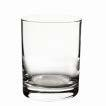

In [41]:
import tarfile
import io
from IPython.display import display

def get_image_from_tar(tar_file, img_path):
    with tarfile.open(tar_file, 'r') as tar:
        f = tar.extractfile(img_path)
        if f is not None:
            img_data = f.read()
            return Image.open(io.BytesIO(img_data))
        
image = get_image_from_tar('D:/abo-images-small.tar', 'images/small/14/14fe8812.jpg')
display(image)


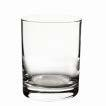

In [9]:
image = Image.open('D:/images/small/14/14fe8812.jpg')
display(image)

In [14]:
def get_all_image_ids(row):
    image_ids = []
    if isinstance(row['main_image_id'], str):
        image_ids.append(row['main_image_id'])
    if isinstance(row['other_image_id'], list):
        image_ids.extend(row['other_image_id'])
    
    return image_ids

In [ ]:
pdf_has_images = pdf_sample[~pdf_sample['main_image_id'].isna() | ~pdf_sample['other_image_id'].isna()]

image_categroy_match = {'image_id': [], 'item_id': [], 'product_type': [], 'match': []}

for item_id in tqdm(pdf_has_images.index):
    row = pdf_has_images.loc[item_id]
    product_type = row['product_type']
    
    image_ids = get_all_image_ids(row)
    
    for image_id in image_ids:
        image_path = 'D:/images/small/' + image_meta_df.loc[image_id, 'path']
        image = Image.open(image_path)
        match = llama_check_image_category(product_type, image)
        image_categroy_match['image_id'].append(image_id)
        image_categroy_match['item_id'].append(item_id)
        image_categroy_match['product_type'].append(product_type)
        image_categroy_match['match'].append(match)
        
image_categroy_match_df = pd.DataFrame(image_categroy_match).set_index('image_id')

100%|██████████| 3773/3773 [4:26:59<00:00,  4.25s/it]  


In [99]:
# image_categroy_match_df.to_pickle("../../ABO_dataset/sample-image-category-match.pkl")
image_categroy_match_df = pd.read_pickle("../../ABO_dataset/sample-image-category-match.pkl")
image_categroy_match_df

,item_id,product_type,match
image_id,,,
51ZvgucquXL,B083VHXTQ1,BEAUTY,Yes
51PSBY8h8LL,B083VHXTQ1,BEAUTY,Yes
61ZcL8JqMVL,B083VHXTQ1,BEAUTY,Yes
61ZomqVpklL,B083VHXTQ1,BEAUTY,Yes
61ykRDS8vOL,B083VHXTQ1,BEAUTY,Yes
...,...,...,...
71T2SKMquUL,B07D2Q4CY7,WRITING PAPER,Yes
91qsUZuMo0L,B07D2Q4CY7,WRITING PAPER,Yes
71VjDJf5DFL,B07D2Q4CY7,WRITING PAPER,Yes


There are a lot of mismatches, so we need a way to filter them further. The way I'm going to handle it is to check for a majority of images for a product matching or not matching.

In [94]:
def get_mismatch_item_ids(image_text_match_df):
    mismatch_df = image_text_match_df[image_text_match_df['match']!='Yes']
    mismatch_item_ids = []
    for item_id in mismatch_df['item_id'].unique():
        item_match = image_text_match_df[image_text_match_df['item_id']==item_id]['match']
        yes_no_counts = item_match.groupby(item_match).size()
        if 'No' not in yes_no_counts.index:
            continue
        elif 'Yes' not in yes_no_counts.index or yes_no_counts['No'] >= yes_no_counts['Yes']:
            mismatch_item_ids.append(item_id)
    return mismatch_item_ids

mismatch_category_item_ids = get_mismatch_item_ids(image_categroy_match_df)

In [95]:
len(mismatch_category_item_ids)

465

Llama looks like it could be correct with a lot of these items. So, we have some options. We could just drop them, as they're a little more than 1% of the sample we're working with. Alternatively, we can try to filter some more by using the item name. I think the second won't take too much work, so I'm going to try it.

In [101]:
import ipywidgets as widgets

def display_item_images(item_id):
    image_ids = get_all_image_ids(pdf_sample.loc[item_id])
    images = []
    for image_id in image_ids:
        imgpath = 'D:/images/small/' + image_meta_df.loc[image_id, 'path']
        img = open(imgpath, 'rb').read()
        height = image_meta_df.loc[image_id]['height']
        width = image_meta_df.loc[image_id]['width']
        widget = widgets.Image(value=img, format='jpg', width=width, height=height)
        images.append(widget)
    box = widgets.HBox(images)
    display(box)

item_id = mismatch_category_item_ids[0]
print(pdf_sample.loc[item_id])
product_type = pdf_sample.loc[item_id, 'product_type']
print(f'\nProduct category: {product_type}')
display_item_images(item_id)

brand                                                       AmazonBasics
bullet_point           [Apple MFi certified charging and syncing cabl...
color                                                              White
fabric_type                                                          NaN
item_name              AmazonBasics Lightning to USB A Cable, Apple M...
item_weight                                                       0.6031
model_name                                                           NaN
product_type                                                        BOOK
style                                                             2-Pack
main_image_id                                                613jL3B7XZL
other_image_id                   [71jOGlpnX2L, 819JTdYhJ2L, 41cGMNX3hiL]
country                                                               US
marketplace                                                       Amazon
domain_name                                        

The code to have Llama-3.2-11B-vision check the image against the product name

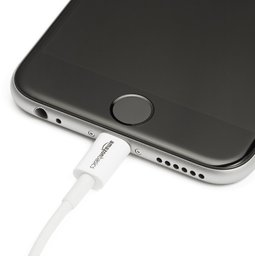

Yes


In [133]:
def llama_check_image_name(item_name, image):
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": f"Answer yes or no without details: Does something in this image resemble {item_name}?"}
        ]}
    ]
    input_text = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    inputs = processor(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to(model.device)

    output = model.generate(**inputs, max_length=100)
    return processor.decode(output[0])[-14:-11].strip()

image = Image.open('D:/images/small/5f/5fe9add0.jpg')
display(image)
product_type = 'AmazonBasics Lightning to USB A Cable, Apple MFi Certified, White, 3 Feet /0.9 Meters, 2-Pack'
print(llama_check_image_category(product_type, image))

In [117]:
image_item_name_match = {'image_id': [], 'item_id': [], 'item_name': [], 'match': []}

for item_id in tqdm(mismatch_category_item_ids):
    item_name = pdf_sample.loc[item_id, 'item_name']
    image_ids = image_categroy_match_df[image_categroy_match_df['item_id']==item_id].index
    for image_id in image_ids:
        image_path = 'D:/images/small/' + image_meta_df.loc[image_id, 'path']
        image = Image.open(image_path)
        match = llama_check_image_name(item_name, image)
        image_item_name_match['image_id'].append(image_id)
        image_item_name_match['item_id'].append(item_id)
        image_item_name_match['item_name'].append(item_name)
        image_item_name_match['match'].append(match)
        
image_item_name_match_df = pd.DataFrame(image_item_name_match).set_index('image_id')

100%|██████████| 465/465 [30:40<00:00,  3.96s/it]


In [118]:
image_item_name_match_df.to_pickle("../../ABO_dataset/sample-image-item-name-match.pkl")
image_item_name_match_df = pd.read_pickle("../../ABO_dataset/sample-image-item-name-match.pkl")
image_item_name_match_df

,item_id,item_name,match
image_id,,,
613jL3B7XZL,B017YEAR0C,"AmazonBasics Lightning to USB A Cable, Apple M...",Yes
71jOGlpnX2L,B017YEAR0C,"AmazonBasics Lightning to USB A Cable, Apple M...",Yes
819JTdYhJ2L,B017YEAR0C,"AmazonBasics Lightning to USB A Cable, Apple M...",No
41cGMNX3hiL,B017YEAR0C,"AmazonBasics Lightning to USB A Cable, Apple M...",Yes
71EQpADJC6L,B0773JY6T2,AmazonBasics 40W 4-Port USB Wall Charger - White,Yes
...,...,...,...
91GxzXiUI2L,B0739X3GPT,"AmazonBasics Correction Tape, 10-Pack",Yes
91z5kHauNiL,B0739X3GPT,"AmazonBasics Correction Tape, 10-Pack",Yes
61rm8ukodvL,B07CWVS9D8,AmazonBasics PlayStation 4 Controller Thumb Gr...,Yes


In [119]:
mismatch_name_item_ids = get_mismatch_item_ids(image_item_name_match_df)
len(mismatch_name_item_ids)

100

In [149]:
item_id = mismatch_name_item_ids[70]
print(pdf_sample.loc[item_id, 'item_name'])
display_item_images(item_id)

AmazonBasics 16 Inch School Classroom Stack Chair, Chrome Legs, Yellow, 6-Pack


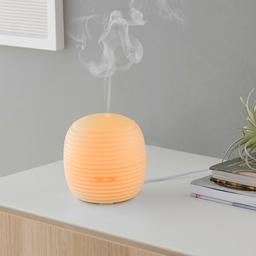

No


In [144]:
image_ids = get_all_image_ids(pdf_sample.loc[item_id])
item_name = pdf_sample.loc[item_id, 'item_name']
imgpath = 'D:/images/small/' + image_meta_df.loc[image_ids[1], 'path']
image = Image.open(imgpath)
display(image)
match = llama_check_image_name(item_name, image)
print(match)